In [1]:
from lbg_forecast.likelihood import pack_params
from lbg_forecast.likelihood import unpack_params
from lbg_forecast.likelihood import get_cosmo_params
from lbg_forecast.likelihood import Likelihood

from lbg_forecast.angular_power import define_cosmo
from lbg_forecast.angular_power import pk

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


In [2]:
lhood = Likelihood()

Initialising likelihood
Initialisation Complete


In [3]:
def forecast_derived():
    o_m = lhood._cosmo_fid.Omega_c + lhood._cosmo_fid.Omega_b
    s8 = lhood._cosmo_fid.sigma8*np.sqrt(o_m/0.3)

    params = np.array([lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r,
                    o_m, s8])

    labels = np.array(["$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$",
                        "$\Omega_{m}$", "$S_{8}$"])

    inds = [2, 3, 4, 6, 7, 8, 9, 10]

    F = lhood.fisher_deriv(params, inds)
    F_marg = lhood.fisher_marg_deriv(params, inds)

    return F, F_marg, params, labels


In [4]:
def forecast():

    params = np.array([lhood._cosmo_fid.sigma8, 
                    lhood._cosmo_fid.Omega_c, lhood._cosmo_fid.Omega_b,
                    lhood._cosmo_fid.h, lhood._cosmo_fid.n_s,
                    lhood._b_lbg_u, lhood._b_lbg_g, lhood._b_lbg_r])

    #w&w stuff
    #norm_diff = pk(define_cosmo(), 1/8, 2.6)/pk(define_cosmo(), 1/8, 0)
    #params = np.array([lhood._cosmo_fid.sigma8*np.sqrt(norm_diff), lhood._b_lbg])

    labels = np.array(["$\sigma_{8}$", "$\Omega_{c}$", "$\Omega_{b}$",
                        "$h$", "$n_{s}$", "$b^{lbg}_{u}$", "$b^{lbg}_{g}$", "$b^{lbg}_{r}$"])

    inds = np.array([0, 1, 2, 3, 4, 6, 7, 8])

    F = lhood.fisher(params, inds)
    F_marg = lhood.fisher_marg(params, inds)

    return F, F_marg, params, labels

In [5]:
F, F_marg, params, labels = forecast_derived()

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=2., K=5.991, ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  inds = [i, j]
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  #width, height = 2 * nstd * np.sqrt(vals)
  width, height = 2 * np.sqrt(vals*K)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)

  xticks = np.delete(np.around(np.linspace(pos[inds[0]] - s1, pos[inds[0]] + s1, 7), 3)[1:6], [1, 3])

  ax.set_xticks(np.around(xticks, 3))

  plt.draw()
  return ellip

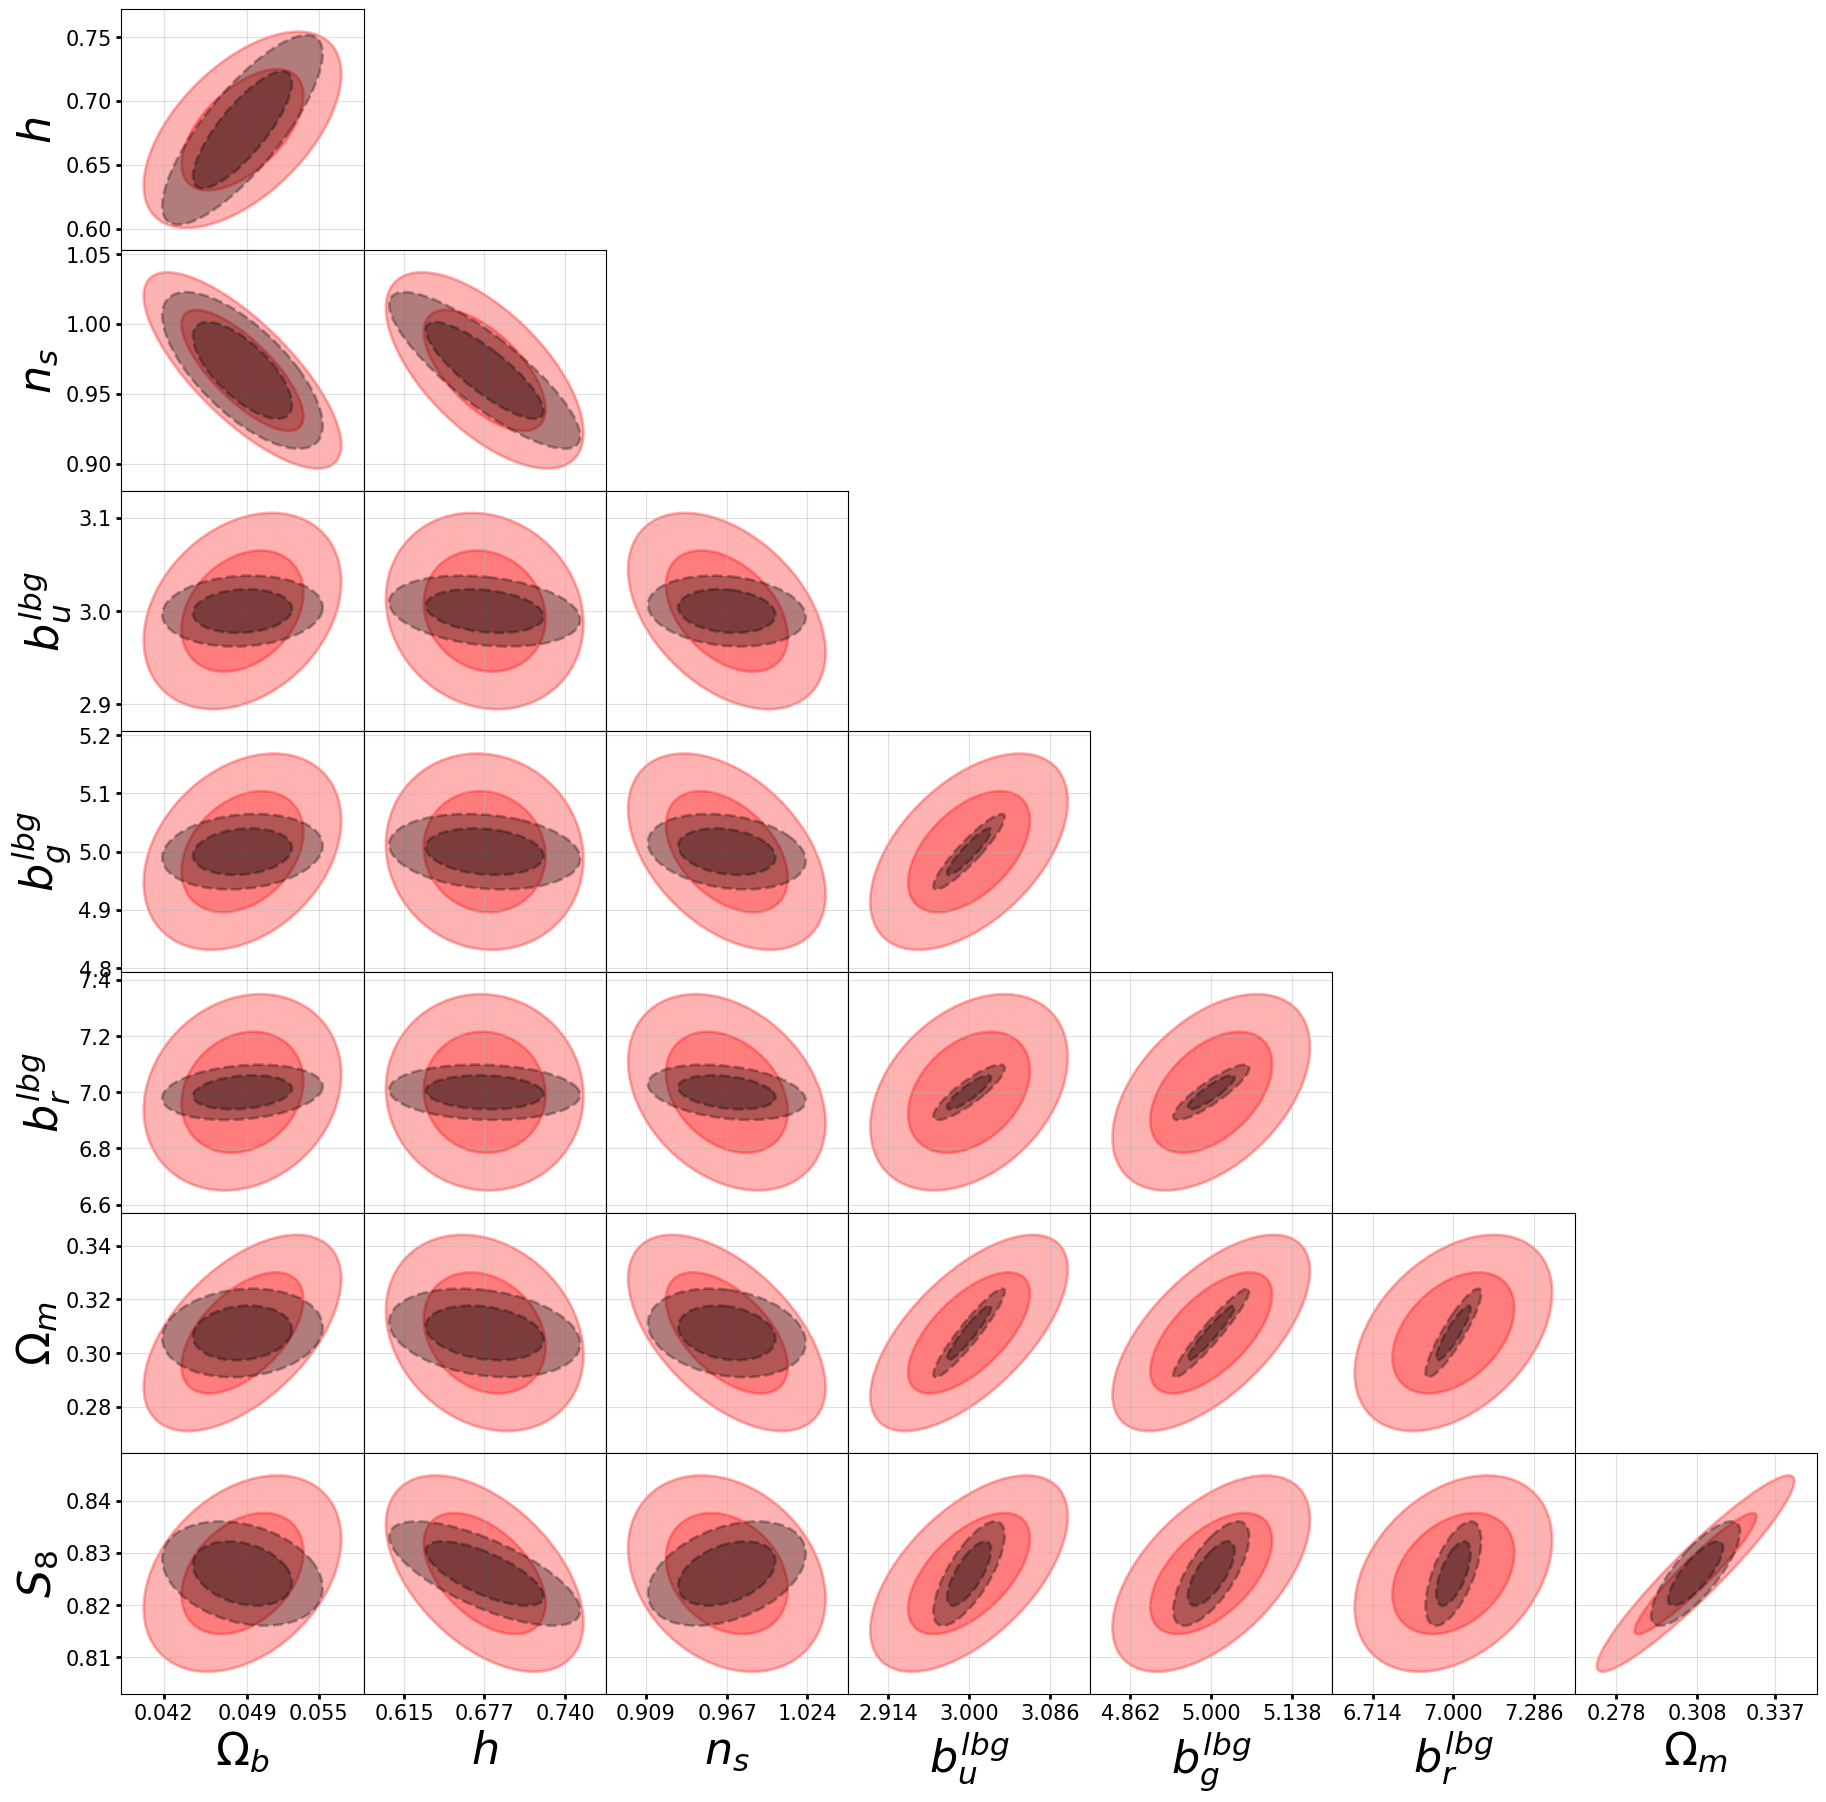

In [7]:
plt.figure(figsize=(25, 25))
nparams = len(params)

#randnos = np.random.multivariate_normal(np.array([params[0], params[1]]),
#                                         np.linalg.inv(F), 1000)
for i in range(nparams):
    for j in range(nparams):
        if j<i:
            plt.subplot(nparams,nparams,i*nparams+j+1)
            plt.subplots_adjust(wspace=0, hspace=0)


            plt.grid(alpha=0.4, zorder=-1)

            plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
            plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)
            #plot_contours(F, params, j, i, K=9.210, fill=True,color='b',  alpha=0.3, zorder=5)
            #plot_contours(F, params, j, i, K=11.618, fill=True,color='b',  alpha=0.3, zorder=5)

            plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
            plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
            #plot_contours(F_marg, params, j, i, K=9.210, fill=True,color='r',  alpha=0.3, zorder=1)
            #plot_contours(F_marg, params, j, i, K=11.618, fill=True,color='r', alpha=0.3, zorder=1)
            

            if(j == 0):
                plt.ylabel(labels[i], fontsize = 32)

            if(i == nparams-1):
                plt.xlabel(labels[j], fontsize = 32)

            plt.tick_params(axis="x", width = 2, labelsize=15)
            plt.tick_params(axis="y", width = 2, labelsize=15)

            if(i < len(params) - 1):
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    labelbottom=False)
                
            if(j > 0):
                plt.tick_params(
                    axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,        # ticks along the bottom edge are off
                    labelleft=False)
            #plt.scatter(randnos[:,0], randnos[:, 1], c ='r', zorder=100, alpha=.5, s=10)
                
                
            

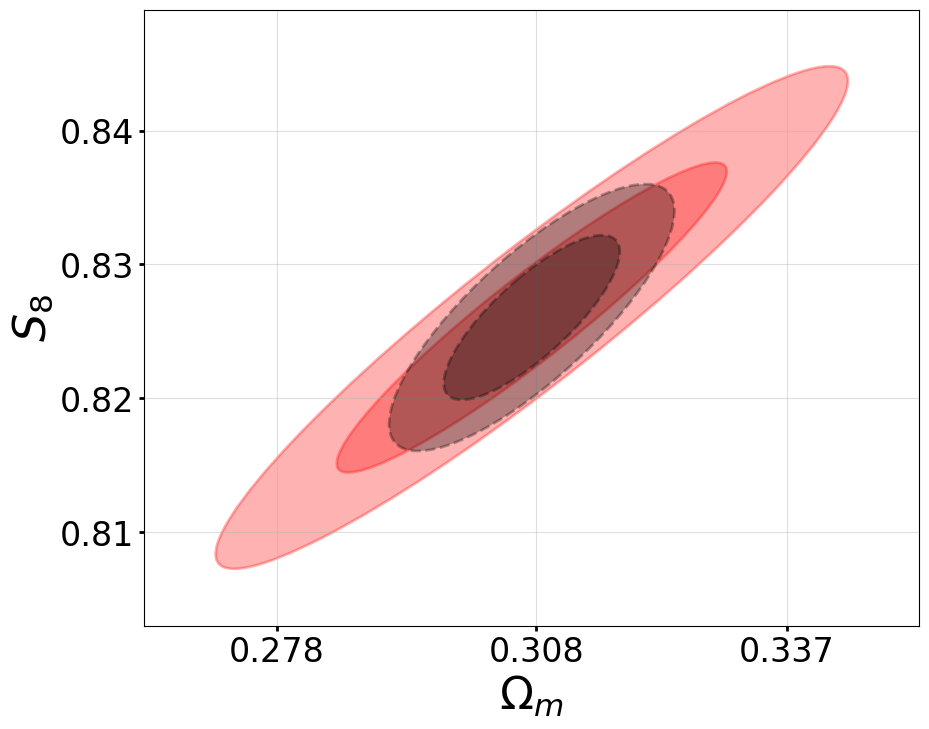

In [8]:
i = 7
j = 6
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.4, zorder=-1)

plot_contours(F, params, j, i, K=2.279, fill=True,color='k', alpha=0.3, zorder=5, ls="--", lw=2)
plot_contours(F, params, j, i, K=5.991, fill=True,color='k',  alpha=0.3, zorder=5, ls="--", lw=2)

plot_contours(F_marg, params, j, i, K=2.279, fill=True,color='r', alpha=0.3, zorder=1, lw=2)
plot_contours(F_marg, params, j, i, K=5.991, fill=True,color='r', alpha=0.3, zorder=1, lw=2)

plt.ylabel(labels[i], fontsize = 32)
plt.xlabel(labels[j], fontsize = 32)

plt.tick_params(axis="x", width = 2, labelsize=24)
plt.tick_params(axis="y", width = 2, labelsize=24)
